In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-nm_7hora
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-nm_7hora
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=e161b4256fd298400026e88874c6a71a546df518643a2268dacd95158da0a17b
  Stored in directory: /tmp/pip-ephem-wheel-cache-792rx293/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [2]:
import math
import torch
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, Solver
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer as a tool to more efficiently optimize deep networks.
  

In [3]:
def get_CIFAR10_data(validation_ratio=0.05, cuda=False, reshape_to_2d=False,
                     visualize=False):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Load every data on cuda
  if cuda:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  if visualize:
    img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  if reshape_to_2d:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Take the validation set from the training set
  # Note: It should not be taken from the test set
  # For random permumation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # return the dataset
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.6/dist-packages/coutils/utils.py:54: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idxs = (y_data == y).nonzero().view(-1)


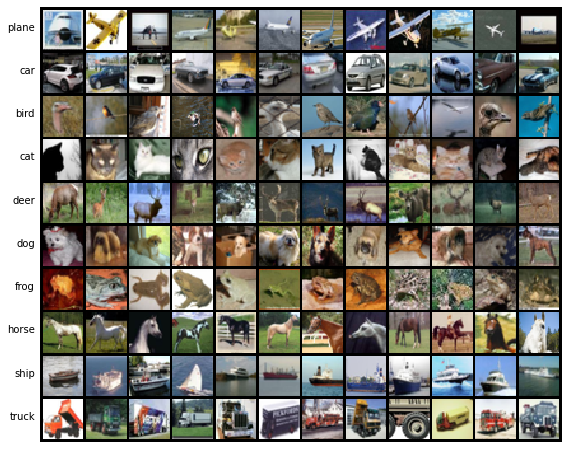

Train data shape:  torch.Size([47500, 3, 32, 32])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3, 32, 32])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [4]:
# Invoke the above function to get our data.
data_dict = get_CIFAR10_data(visualize=True)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

In [5]:
'''
try:
    x = int(input('3의 배수를 입력하세요: '))
    if x % 3 != 0:                                 # x가 3의 배수가 아니면
        raise Exception('3의 배수가 아닙니다.')    # 예외를 발생시킴
    print(x)
except Exception as e:                             # 예외가 발생했을 때 실행됨
    print('예외가 발생했습니다.', e)
# 190이 넘는 학생을 발견하면 반복을 종료한다.
school = {'1반' : [150, 156, 179, 191, 199], '2반' : [150, 195, 179, 191, 199]}

try:
    for class_number, students in school.items():
        for student in students:
            if student > 190:
                print(class_number, '190을 넘는 학생이 있습니다.')
                # break # 바로 상위 for문은 종료되지만 최고 상위 for문은 종료되지 않는다.
                raise StopIteration
                # 예외가 try 문 안에 있지 않으면 에러 발생시 프로그램이 멈춘다.
except StopIteration:
    print('정상종료')                
'''

"\ntry:\n    x = int(input('3의 배수를 입력하세요: '))\n    if x % 3 != 0:                                 # x가 3의 배수가 아니면\n        raise Exception('3의 배수가 아닙니다.')    # 예외를 발생시킴\n    print(x)\nexcept Exception as e:                             # 예외가 발생했을 때 실행됨\n    print('예외가 발생했습니다.', e)\n# 190이 넘는 학생을 발견하면 반복을 종료한다.\nschool = {'1반' : [150, 156, 179, 191, 199], '2반' : [150, 195, 179, 191, 199]}\n\ntry:\n    for class_number, students in school.items():\n        for student in students:\n            if student > 190:\n                print(class_number, '190을 넘는 학생이 있습니다.')\n                # break # 바로 상위 for문은 종료되지만 최고 상위 for문은 종료되지 않는다.\n                raise StopIteration\n                # 예외가 try 문 안에 있지 않으면 에러 발생시 프로그램이 멈춘다.\nexcept StopIteration:\n    print('정상종료')                \n"

In [6]:
class Linear(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

In [7]:
def linear_forward(x, w, b):
  """
  Computes the forward pass for an linear (fully-connected) layer.
  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.
  Inputs:
  - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
  - w: A tensor of weights, of shape (D, M)
  - b: A tensor of biases, of shape (M,)
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  #############################################################################
  # TODO: Implement the linear forward pass. Store the result in out. You     #
  # will need to reshape the input into rows.                                 #
  #############################################################################
  # Replace "pass" statement with your code
  x_prime = x.reshape(x.shape[0], -1)
  out = torch.mm(x_prime,w) + b
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, w, b)
  return out, cache

Linear.forward = linear_forward

In [8]:
num_inputs = 2
input_shape = torch.tensor((4,5,6))
output_dim = 3
# torch.prod: 원소 곱셈
input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, **to_double_cuda).reshape(num_inputs, *input_shape)
w = torch.linspace(-0.2, 0.3, steps=weight_size, **to_double_cuda).reshape(torch.prod(input_shape), output_dim)
b = torch.linspace(-0.3, 0.1, steps=output_dim, **to_double_cuda)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[ 1.49834967,  1.70660132,  1.91485297],
                            [ 3.25553199,  3.5141327,   3.77273342]],
                            **to_double_cuda)
print('Testing Linear.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing Linear.forward function:
difference:  1.9539697795885023e-09


In [9]:
def linear_backward(dout, cache):
    """
  Computes the backward pass for an linear layer.
  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)
    - b: Biases, of shape (M,)
  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
    x, w, b = cache
    dx, dw, db = None, None, None

    N = x.shape[0]
    dx = torch.mm(dout, w.t()).reshape(x.shape)
    dw = torch.mm((x.reshape(N, -1)).t(), dout)
    db = torch.sum(dout, dim=0)

    return dx, dw, db

Linear.backward = linear_backward

In [10]:
a = {'1': 2, '2': 3}
print(*a)

1 2


In [11]:
# Test the Linear.backward function
fix_random_seed(0)
x = torch.randn(10, 2, 3, **to_double_cuda)
w = torch.randn(6, 5, **to_double_cuda)
b = torch.randn(5, **to_double_cuda)
dout = torch.randn(10, 5, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear.backward function:
dx error:  2.340771536181963e-09
dw error:  6.573349127694478e-11
db error:  4.357966842062988e-11


In [12]:
class ReLU(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

In [13]:
def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).
  Input:
  - x: Input; a tensor of any shape
  Returns a tuple of:
  - out: Output, a tensor of the same shape as x
  - cache: x
  """
  out = None
  #############################################################################
  # TODO: Implement the ReLU forward pass.                                    #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  out = torch.max(torch.zeros_like(x), x)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = x
  return out, cache

ReLU.forward = relu_forward

In [14]:
# Test the relu_forward function
x = torch.linspace(-0.5, 0.5, steps=12, **to_double_cuda).reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            **to_double_cuda)

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  9.999999034982122e-08


In [15]:
def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).
  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout
  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  #############################################################################
  # TODO: Implement the ReLU backward pass.                                   #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  dout[x <= 0] = 0
  dx = dout
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx

ReLU.backward = relu_backward

In [16]:
fix_random_seed(0)
x = torch.randn(10, 10, **to_double_cuda)
dout = torch.randn(*x.shape, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  6.5510464861138194e-12


In [17]:
class Linear_ReLU(object):

  @staticmethod
  def forward(x, w, b):
    """
    Convenience layer that perorms an linear transform followed by a ReLU.

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = Linear.forward(x, w, b)
    out, relu_cache = ReLU.forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db

In [18]:
fix_random_seed(0)
x = torch.randn(2, 3, 4, **to_double_cuda)
w = torch.randn(12, 10, **to_double_cuda)
b = torch.randn(10, **to_double_cuda)
dout = torch.randn(2, 10, **to_double_cuda)

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  5.0562785959952e-10
dw error:  1.8447601369756057e-09
db error:  5.0959990317728124e-11


In [19]:
def svm_loss(x, y):
    N = x.shape[0]
    correct_class_scores = x[torch.arange(N), y]
    margins = (x - correct_class_scores[:,None]+1.0).clamp(min=0.)
    margins[torch.arange(N), y] = 0
    loss = torch.sum(margins) / N
    num_pos = (margins > 0).sum(dim=1)
    dx = torch.zeros_like(x)
    dx[margins>0] = 1
    dx[torch.arange(N), y] -= num_pos.to(dx.dtype)
    dx /= N
    return loss, dx

def softmax_loss(x, y):
    shifted_logits = x - x.max(dim=1, keepdim=True).values
    Z = shifted_logits.exp().sum(dim=1, keepdim=True)
    log_probs = shifted_logits - Z.log()
    probs = log_probs.exp()
    N = x.shape[0]
    loss =(-1.0 / N) * log_probs[torch.arange(N), y].sum()
    dx = probs.clone()
    dx[torch.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [20]:
y = torch.tensor([1,2,0])
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
a = x[torch.arange(3), y]
print(a)
print(a[:,None])
print(torch.sum(x))
print(x-a[:,None])

tensor([2, 6, 7])
tensor([[2],
        [6],
        [7]])
tensor(45)
tensor([[-1,  0,  1],
        [-2, -1,  0],
        [ 0,  1,  2]])


In [21]:
fix_random_seed(0)
num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

dx_num = compute_numeric_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

dx_num = compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.000430792478463
dx error:  2.8043130317900733e-09

Testing softmax_loss:
loss:  2.3026286102347924
dx error:  1.9329571390449453e-08


In [22]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  The architecure should be linear - relu - linear - softmax.
  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to PyTorch tensors.
  """

  def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
         weight_scale=1e-3, reg=0.0, dtype=torch.float32, device='cpu'):
    """
    Initialize a new networ
    
    
    
    k.
    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dim: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.params = {}
    self.reg = reg

    ###########################################################################
    # TODO: Initialize the weights and biases of the two-layer net. Weights   #
    # should be initialized from a Gaussian centered at 0.0 with              #
    # standard deviation equal to weight_scale, and biases should be          #
    # initialized to zero. All weights and biases should be stored in the     #
    # dictionary self.params, with first layer weights                        #
    # and biases using the keys 'W1' and 'b1' and second layer                #
    # weights and biases using the keys 'W2' and 'b2'.                        #
    ###########################################################################
    # Replace "pass" statement with your code
    self.params['W1'] = weight_scale * torch.randn(input_dim, hidden_dim).to(device).to(dtype)
    self.params['b1'] = torch.zeros(hidden_dim).to(device).to(dtype)
    self.params['W2'] = weight_scale * torch.randn(hidden_dim, num_classes).to(device).to(dtype)
    self.params['b2'] = torch.zeros(num_classes).to(device).to(dtype)
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################


  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Tensor of input data of shape (N, d_1, ..., d_k)
    - y: int64 Tensor of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Tensor of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.
    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """
    scores = None
    ###########################################################################
    # TODO: Implement the forward pass for the two-layer net, computing the   #
    # class scores for X and storing them in the scores variable.             #
    ###########################################################################
    # Replace "pass" statement with your code
    hidden, cache_first = Linear_ReLU.forward(X, self.params['W1'], self.params['b1'])
    scores, cache_second = Linear.forward(hidden, self.params['W2'], self.params['b2'])
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores

    loss, grads = 0, {}
    ###########################################################################
    # TODO: Implement the backward pass for the two-layer net. Store the loss #
    # in the loss variable and gradients in the grads dictionary. Compute data#
    # loss using softmax, and make sure that grads[k] holds the gradients for #
    # self.params[k]. Don't forget to add L2 regularization!                  #
    #                                                                         #
    # NOTE: To ensure that your implementation matches ours and you pass the  #
    # automated tests, make sure that your L2 regularization does not include #
    # a factor of 0.5.                                                        #
    ###########################################################################
    # Replace "pass" statement with your code
    soft_loss, softmax_grad = softmax_loss(scores, y)
    loss = soft_loss + self.reg * (torch.sum(self.params['W1'] * self.params['W1']) + (torch.sum(self.params['W2'] * self.params['W2'])))
    
    dhidden, grads['W2'], grads['b2'] = Linear.backward(softmax_grad, cache_second)
    grads['W2'] += 2 * self.reg * self.params['W2']

    dx, grads['W1'], grads['b1'] = Linear_ReLU.backward(dhidden, cache_first)
    grads['W1'] += 2 * self.reg * self.params['W1']
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    return loss, grads

In [23]:
fix_random_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std,
                    **to_double_cuda)

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D*H, **to_double_cuda).reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, **to_double_cuda)
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H*C, **to_double_cuda).reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, **to_double_cuda)
X = torch.linspace(-5.5, 4.5, steps=N*D, **to_double_cuda).reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    **to_double_cuda)
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 4.28e-08
W2 relative error: 7.01e-10
b1 relative error: 2.77e-08
b2 relative error: 6.15e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 5.74e-08
W2 relative error: 6.61e-07
b1 relative error: 3.13e-08
b2 relative error: 1.78e-09


In [24]:
print(help(Solver))

Help on class Solver in module coutils.solver:

class Solver(builtins.object)
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.loss_history will contain a list
 |  of all losses encountered during training and

In [25]:
fix_random_seed(0)
model = TwoLayerNet(dtype=torch.float, device='cuda')
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Replace "pass" statement with your code
solver = Solver(model, data_dict, lr_decay=0.95, optim_config={'learning_rate': 1e-1,},num_epochs=20, print_every=100, batch_size=100, device='cuda')
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Time 0.01 sec; Iteration 1 / 9500) loss: 2.302590
(Epoch 0 / 20) train acc: 0.101000; val_acc: 0.103200
(Time 0.34 sec; Iteration 101 / 9500) loss: 2.202432
(Time 0.62 sec; Iteration 201 / 9500) loss: 1.961441
(Time 0.90 sec; Iteration 301 / 9500) loss: 2.026095
(Time 1.19 sec; Iteration 401 / 9500) loss: 1.850581
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.363200
(Time 1.50 sec; Iteration 501 / 9500) loss: 1.625198
(Time 1.79 sec; Iteration 601 / 9500) loss: 1.571927
(Time 2.07 sec; Iteration 701 / 9500) loss: 1.737323
(Time 2.35 sec; Iteration 801 / 9500) loss: 1.517222
(Time 2.63 sec; Iteration 901 / 9500) loss: 1.604458
(Epoch 2 / 20) train acc: 0.429000; val_acc: 0.443200
(Time 2.93 sec; Iteration 1001 / 9500) loss: 1.633343
(Time 3.22 sec; Iteration 1101 / 9500) loss: 1.511423
(Time 3.49 sec; Iteration 1201 / 9500) loss: 1.745143
(Time 3.77 sec; Iteration 1301 / 9500) loss: 1.627591
(Time 4.05 sec; Iteration 1401 / 9500) loss: 1.622213
(Epoch 3 / 20) train acc: 0.492000; val_

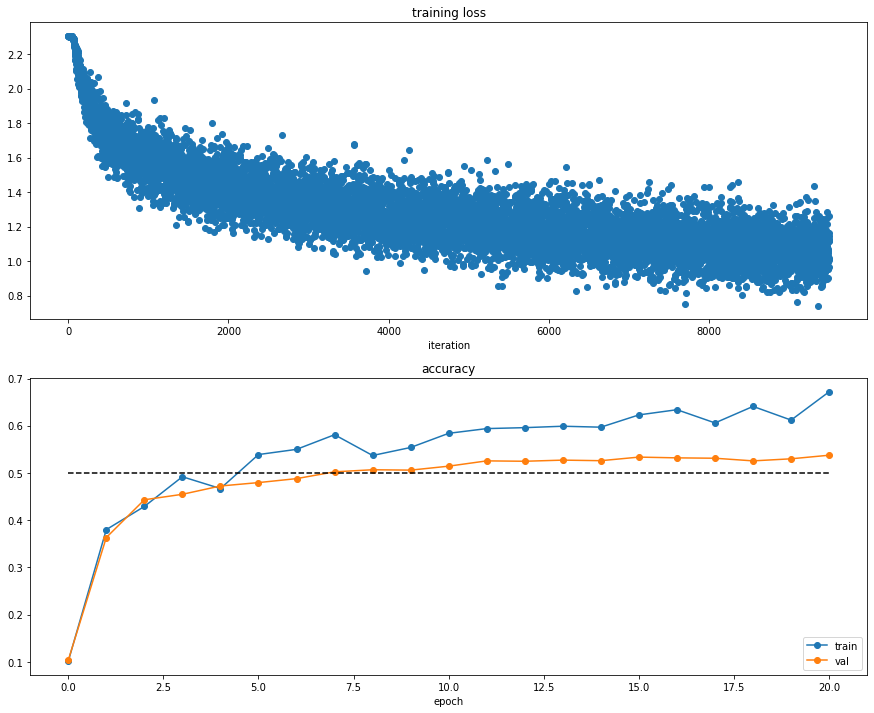

In [26]:
plt.subplot(2, 1, 1)
plt.title('training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')

plt.subplot(2,1,2)
plt.title('accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history,'-o',label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15,12)
plt.show()

In [27]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function.
  For a network with L layers, the architecture will be:

  {linear - relu - [dropout]} x (L - 1) - linear - softmax

  where dropout is optional, and the {...} block is repeated L - 1 times.

  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0.0, reg=0.0, weight_scale=1e-2, seed=None,
               dtype=torch.float, device='cpu'):
    """
    Initialize a new FullyConnectedNet.

    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving the drop probability for networks
      with dropout. If dropout=0 then the network should not use dropout.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.use_dropout = dropout != 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    ############################################################################
    # TODO: Initialize the parameters of the network, storing all values in    #
    # the self.params dictionary. Store weights and biases for the first layer #
    # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
    # initialized from a normal distribution centered at 0 with standard       #
    # deviation equal to weight_scale. Biases should be initialized to zero.   #
    ############################################################################
    # Replace "pass" statement with your code
    dims = [input_dim] + hidden_dims + [num_classes] # 행렬 붙이기
    for i in range(self.num_layers):
        self.params[f'W{i+1}'] = weight_scale * torch.randn(dims[i], dims[i+1], dtype=dtype, device=device)
        self.params[f'b{i+1}'] = torch.zeros(dims[i+1], dtype=dtype, device=device)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.
    Input / output: Same as TwoLayerNet above.
    """
    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.use_dropout:
      self.dropout_param['mode'] = mode
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the fully-connected net, computing  #
    # the class scores for X and storing them in the scores variable.          #
    #                                                                          #
    # When using dropout, you'll need to pass self.dropout_param to each       #
    # dropout forward pass.                                                    #
    ############################################################################
    # Replace "pass" statement with your code
    hidden_layer_num = self.num_layers - 1
    scores = X
    cache_history = []
    drop_cache = []
    L2reg = 0
    for i in range(hidden_layer_num):
        scores, cache = Linear_ReLU.forward(scores, self.params[f'W{i+1}'], self.params[f'b{i+1}'])
        cache_history.append(cache)
        L2reg += self.reg * torch.sum(self.params[f'W{i+1}'] ** 2)
        # dropout
        if self.use_dropout:
            scores, dropped = Dropout.forward(scores, self.dropout_param)
            drop_cache.append(dropped)
    i = hidden_layer_num + 1
    scores, cache = Linear.forward(scores, self.params[f'W{i}'], self.params[f'b{i}'])
    cache_history.append(cache)
    L2reg += self.reg * torch.sum(self.params[f'W{i}'] ** 2)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    ############################################################################
    # TODO: Implement the backward pass for the fully-connected net. Store the #
    # loss in the loss variable and gradients in the grads dictionary. Compute #
    # data loss using softmax, and make sure that grads[k] holds the gradients #
    # for self.params[k]. Don't forget to add L2 regularization!               #
    # NOTE: To ensure that your implementation matches ours and you pass the   #
    # automated tests, make sure that your L2 regularization includes a factor #
    # of 0.5 to simplify the expression for the gradient.                      #
    ############################################################################
    # Replace "pass" statement with your code
    loss, dout = softmax_loss(scores, y)
    loss += L2reg

    dout, grads[f'W{i}'], grads[f'b{i}'] = Linear.backward(dout, cache_history.pop())
    grads[f'W{i}'] += 2* self.reg * self.params[f'W{i}']
    i -= 1
    while i >= 1:
        if self.use_dropout:
            dout = Dropout.backward(dout, drop_cache.pop())
        dout, grads[f'W{i}'], grads[f'b{i}'] = Linear_ReLU.backward(dout, cache_history.pop())
        grads[f'W{i}'] += 2* self.reg * self.params[f'W{i}']
        i -= 1
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return loss, grads

In [28]:
a = [1,2,3]
a = a + [3]
p = {}
for i in range(3):
    p[f'a{i}'] = a[i]
print(p)

{'a0': 1, 'a1': 2, 'a2': 3}


In [29]:
fix_random_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, **to_double_cuda)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3053575717037686
W1 relative error: 7.62e-06
W2 relative error: 3.47e-07
W3 relative error: 1.39e-07
b1 relative error: 4.20e-07
b2 relative error: 3.76e-09
b3 relative error: 2.34e-10
Running check with reg =  3.14
Initial loss:  12.278358041494133
W1 relative error: 1.07e-08
W2 relative error: 8.67e-08
W3 relative error: 3.63e-08
b1 relative error: 1.46e-07
b2 relative error: 4.39e-08
b3 relative error: 1.05e-09


(Time 0.00 sec; Iteration 1 / 40) loss: 27.053200
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.148400
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.119600
(Epoch 2 / 20) train acc: 0.600000; val_acc: 0.139200
(Epoch 3 / 20) train acc: 0.780000; val_acc: 0.154000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.147200
(Epoch 5 / 20) train acc: 0.980000; val_acc: 0.152800
(Time 0.14 sec; Iteration 11 / 40) loss: 0.083689
(Epoch 6 / 20) train acc: 1.000000; val_acc: 0.156400
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.156400
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.155600
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.155600
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.155600
(Time 0.26 sec; Iteration 21 / 40) loss: 0.002234
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.155600
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.155600
(Epoch 15 / 20) train acc: 1.000000

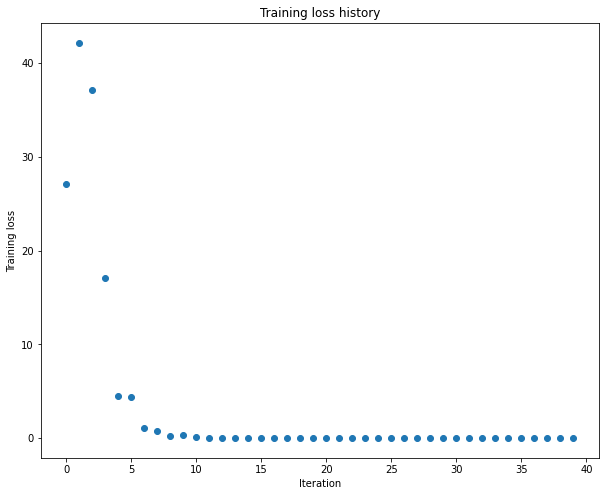

In [30]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
############################################################################
# TODO: Change weight_scale and learning_rate so your model achieves 100%  #
# training accuracy within 20 epochs.                                      #
############################################################################
# Replace "pass" statement with your code
weight_scale = 3e-1
learning_rate = 1e-1
############################################################################
#                             END OF YOUR CODE                             #
############################################################################
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Time 0.01 sec; Iteration 1 / 40) loss: 80.698326
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.107200
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.124800
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.133600
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.142800
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.149200
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.152800
(Time 0.20 sec; Iteration 11 / 40) loss: 0.112559
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.158400
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.153200
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.158000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.157600
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.157600
(Time 0.37 sec; Iteration 21 / 40) loss: 0.000007
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.157600
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.157600
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.157600
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.157600
(Epoch 15 / 20) train acc: 1.000000

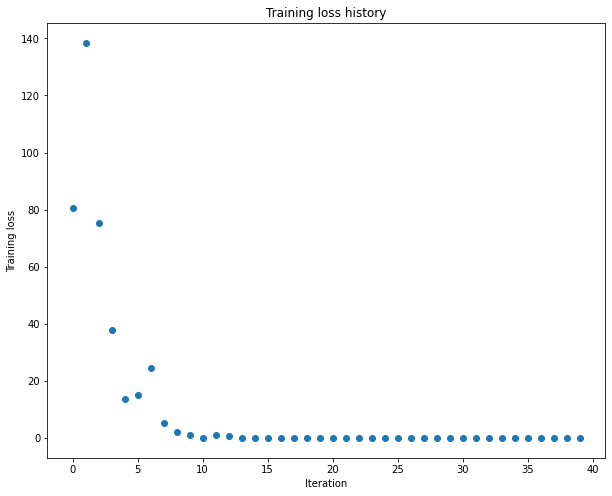

In [31]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1e-5   # Experiment with this!
############################################################################
# TODO: Change weight_scale and learning_rate so your model achieves 100%  #
# training accuracy within 20 epochs.                                      #
############################################################################
# Replace "pass" statement with your code
learning_rate = 1e-2
weight_scale = 3e-1
############################################################################
#                             END OF YOUR CODE                             #
############################################################################
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [32]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.
    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config

In [33]:
def sgd_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with momentum.
  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a
    moving average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9)
  v = config.get('velocity', torch.zeros_like(w))

  next_w = None
  #############################################################################
  # TODO: Implement the momentum update formula. Store the updated value in   #
  # the next_w variable. You should also use and update the velocity v.       #
  #############################################################################
  # Replace "pass" statement with your code
  v = config['momentum'] * v - config['learning_rate'] * dw
  next_w = w + v
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  config['velocity'] = v

  return next_w, config

In [34]:
a = {'1':2, '2': 3}
print(a.get('3',4))
print(a)

4
{'1': 2, '2': 3}


In [35]:
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]],
   **to_double_cuda)
expected_velocity = torch.tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]],
   **to_double_cuda)

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  1.7764694224803817e-08
velocity error:  8.538575450103691e-09


running with  sgd
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302603
(Epoch 0 / 5) train acc: 0.116000; val_acc: 0.090000
(Epoch 1 / 5) train acc: 0.098000; val_acc: 0.093600
(Epoch 2 / 5) train acc: 0.094000; val_acc: 0.093600
(Epoch 3 / 5) train acc: 0.117000; val_acc: 0.093600
(Epoch 4 / 5) train acc: 0.106000; val_acc: 0.089600
(Epoch 5 / 5) train acc: 0.092000; val_acc: 0.093600

running with  sgd_momentum
(Time 0.00 sec; Iteration 1 / 200) loss: 2.302174
(Epoch 0 / 5) train acc: 0.108000; val_acc: 0.100800
(Epoch 1 / 5) train acc: 0.099000; val_acc: 0.087600
(Epoch 2 / 5) train acc: 0.167000; val_acc: 0.184400
(Epoch 3 / 5) train acc: 0.164000; val_acc: 0.162000
(Epoch 4 / 5) train acc: 0.284000; val_acc: 0.252800
(Epoch 5 / 5) train acc: 0.265000; val_acc: 0.251600



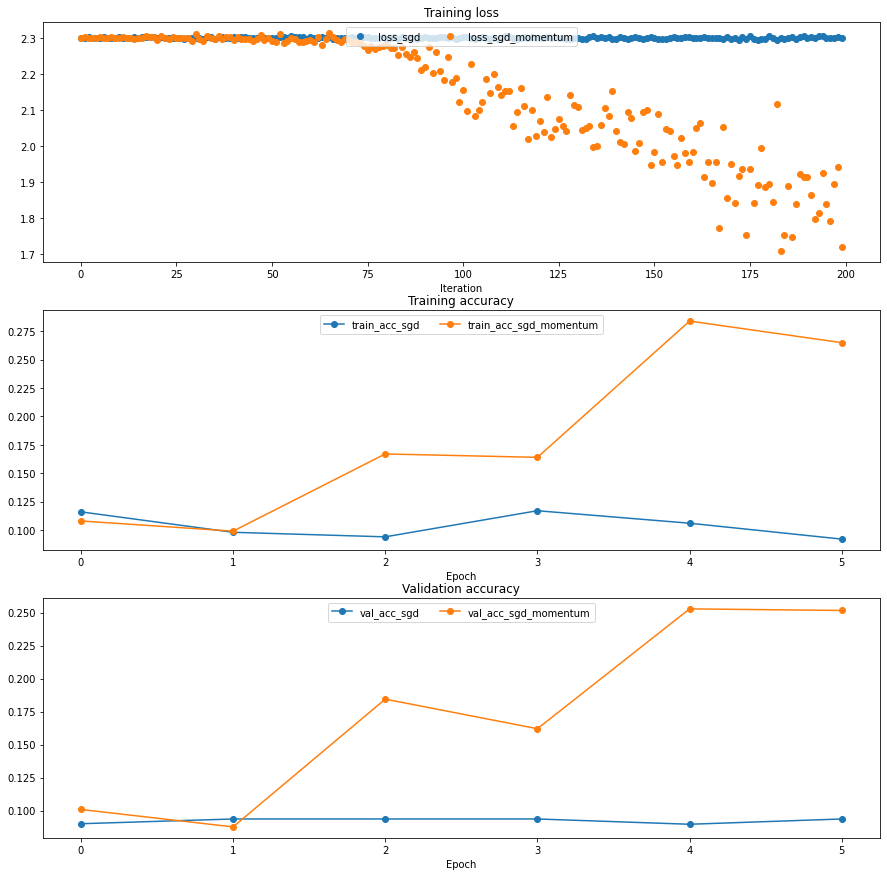

In [36]:
num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            **to_float_cuda)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

In [37]:
def rmsprop(w, dw, config=None):
  """
  Uses the RMSProp update rule, which uses a moving average of squared
  gradient values to set adaptive per-parameter learning rates.
  config format:
  - learning_rate: Scalar learning rate.
  - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
    gradient cache.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - cache: Moving average of second moments of gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('decay_rate', 0.99)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('cache', torch.zeros_like(w))

  next_w = None
  ###########################################################################
  # TODO: Implement the RMSprop update formula, storing the next value of w #
  # in the next_w variable. Don't forget to update cache value stored in    #
  # config['cache'].                                                        #
  ###########################################################################
  # Replace "pass" statement with your code
  lr = config['learning_rate']
  dr = config['decay_rate']
  eps = config['epsilon']
  cache = config['cache']
  cache = dr * cache + (1.0 - dr) * (dw ** 2)
  next_w = w - lr * dw / (cache ** (1/2) + eps)
  config['cache'] = cache
  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return next_w, config

In [38]:
# Test RMSProp implementation
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]],
   **to_double_cuda)
expected_cache = torch.tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]],
   **to_double_cuda)

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  1.9049376836469881e-07
cache error:  5.2955911474095824e-09


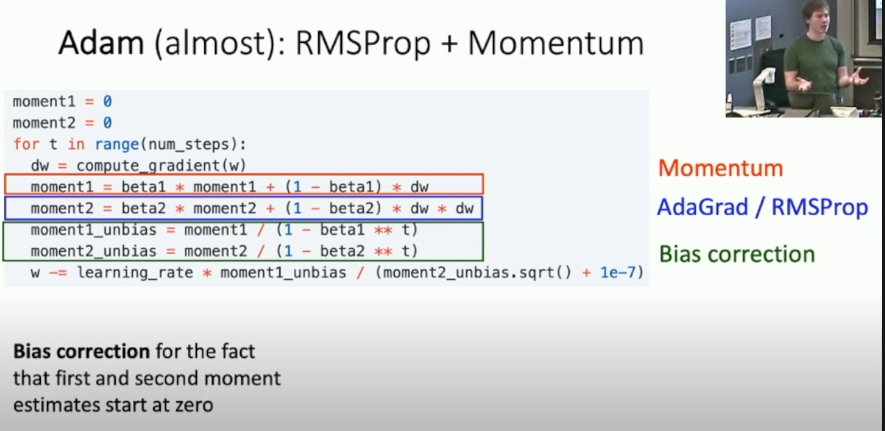

In [39]:
def adam(w, dw, config=None):
  """
  Uses the Adam update rule, which incorporates moving averages of both the
  gradient and its square and a bias correction term.
  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: Moving average of gradient.
  - v: Moving average of squared gradient.
  - t: Iteration number.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('m', torch.zeros_like(w))
  config.setdefault('v', torch.zeros_like(w))
  config.setdefault('t', 0)

  next_w = None
  #############################################################################
  # TODO: Implement the Adam update formula, storing the next value of w in   #
  # the next_w variable. Don't forget to update the m, v, and t variables     #
  # stored in config.                                                         #
  #                                                                           #
  # NOTE: In order to match the reference output, please modify t _before_    #
  # using it in any calculations.                                             #
  #############################################################################
  # Replace "pass" statement with your code
  lr = config['learning_rate']
  beta1 = config['beta1']
  beta2 = config['beta2']
  eps = config['epsilon']
  m = config['m']
  v = config['v']
  t = config['t']

  t = t + 1
  m = beta1 * m + (1 - beta1) * dw
  v = beta2 * v + (1 - beta2) * dw**2
  m_unbias = m / (1 - beta1 ** t)
  v_unbias = v / (1 - beta2 ** t)
  next_w = w - lr * m_unbias / (v_unbias ** (1/2) + eps)
  config['m'] = m
  config['v'] = v
  config['t'] = t

  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

  return next_w, config

In [40]:
# Test Adam implementation
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]],
   **to_double_cuda)
expected_v = torch.tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]],
   **to_double_cuda)
expected_m = torch.tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]],
   **to_double_cuda)

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  2.279138619430699e-07
v error:  8.416628040806327e-09
m error:  8.429926350697003e-09


running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302603
(Epoch 0 / 5) train acc: 0.110000; val_acc: 0.105200
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.267600
(Epoch 2 / 5) train acc: 0.334000; val_acc: 0.281200
(Epoch 3 / 5) train acc: 0.377000; val_acc: 0.326000
(Epoch 4 / 5) train acc: 0.417000; val_acc: 0.348000
(Epoch 5 / 5) train acc: 0.465000; val_acc: 0.380000

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302174
(Epoch 0 / 5) train acc: 0.123000; val_acc: 0.129600
(Epoch 1 / 5) train acc: 0.232000; val_acc: 0.224000
(Epoch 2 / 5) train acc: 0.233000; val_acc: 0.234400
(Epoch 3 / 5) train acc: 0.250000; val_acc: 0.255200
(Epoch 4 / 5) train acc: 0.280000; val_acc: 0.275200
(Epoch 5 / 5) train acc: 0.305000; val_acc: 0.282000



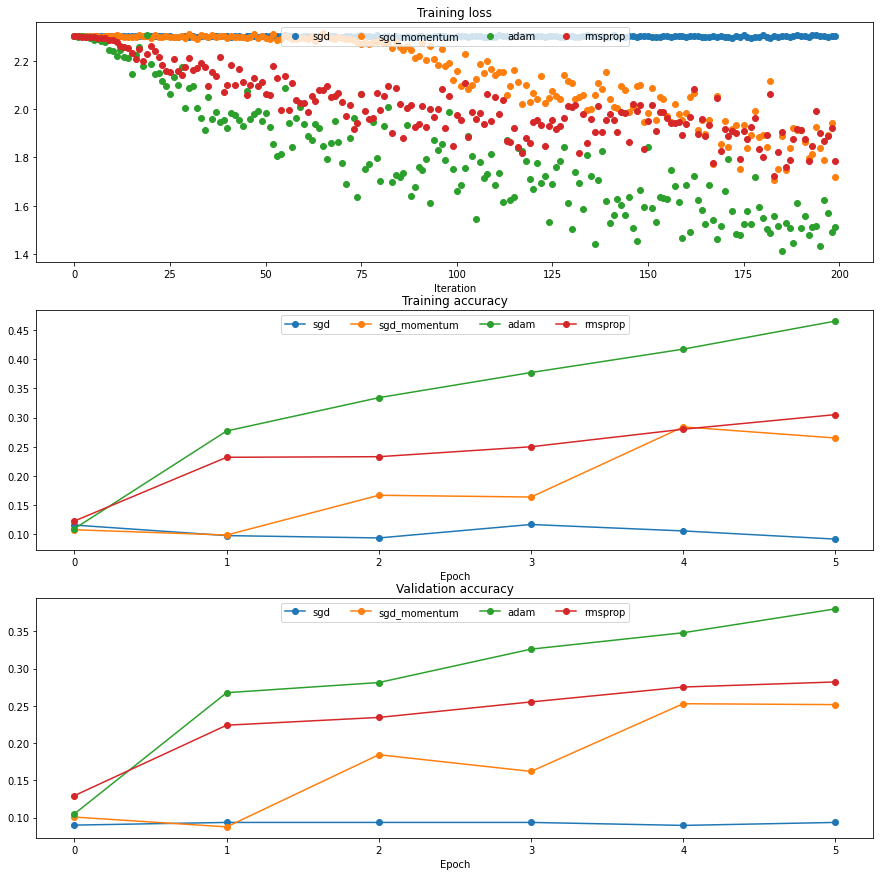

In [41]:
for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

In [42]:
class Dropout(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

In [43]:
def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.
  Inputs:
  - x: Input data: tensor of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We *drop* each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
    if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
    function deterministic, which is needed for gradient checking but not
    in real networks.
  Outputs:
  - out: Tensor of the same shape as x.
  - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  NOTE: Please implement **inverted** dropout, not the vanilla version of dropout.
  See http://cs231n.github.io/neural-networks-2/#reg for more details.
  NOTE 2: Keep in mind that p is the probability of **dropping** a neuron
  output; this might be contrary to some sources, where it is referred to
  as the probability of keeping a neuron output.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    torch.manual_seed(dropout_param['seed'])

  mask = None
  out = None

  if mode == 'train':
    ###########################################################################
    # TODO: Implement training phase forward pass for inverted dropout.       #
    # Store the dropout mask in the mask variable.                            #
    ###########################################################################
    # Replace "pass" statement with your code
    # (1-p)로 나눠서 scaling 해줌
    mask = (torch.rand(*x.shape) < (1-p)).to(x.dtype).to(x.device) / (1-p)
    out = x * mask
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
  elif mode == 'test':
    ###########################################################################
    # TODO: Implement the test phase forward pass for inverted dropout.       #
    ###########################################################################
    # Replace "pass" statement with your code
    out = x
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

  cache = (dropout_param, mask)

  return out, cache

Dropout.forward = dropout_forward

In [44]:
fix_random_seed(0)
x = torch.randn(500, 500, **to_double_cuda) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

Running tests with p =  0.25
Mean of input:  9.99733031060962
Mean of train-time output:  9.989851534106885
Mean of test-time output:  9.99733031060962
Fraction of train-time output set to zero:  0.2505599856376648
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.99733031060962
Mean of train-time output:  9.973639801529279
Mean of test-time output:  9.99733031060962
Fraction of train-time output set to zero:  0.40133199095726013
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.99733031060962
Mean of train-time output:  10.007508879941666
Mean of test-time output:  9.99733031060962
Fraction of train-time output set to zero:  0.6997119784355164
Fraction of test-time output set to zero:  0.0



In [45]:
def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.
  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from Dropout.forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']

  dx = None
  if mode == 'train':
    ###########################################################################
    # TODO: Implement training phase backward pass for inverted dropout       #
    ###########################################################################
    # Replace "pass" statement with your code
    dx = dout * mask
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  elif mode == 'test':
    dx = dout
  return dx

Dropout.backward = dropout_backward

In [46]:
fix_random_seed(0)
x = torch.randn(10, 10, **to_double_cuda) + 10
dout = torch.randn_like(x)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 0}
out, cache = Dropout.forward(x, dropout_param)
dx = Dropout.backward(dout, cache)
dx_num = compute_numeric_gradient(lambda xx: Dropout.forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.0891221439148332e-10


In [47]:
# Train two identical nets, one with dropout and one without
fix_random_seed(0)
num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, **to_float_cuda)
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device='cuda')
  solver.train()
  solvers[(dropout, width)] = solver
  print()

Training a model with dropout=0.00 and width=256
(Time 0.01 sec; Iteration 1 / 3900) loss: 2.304467
(Epoch 0 / 100) train acc: 0.206000; val_acc: 0.200400
(Epoch 10 / 100) train acc: 0.710000; val_acc: 0.484000
(Epoch 20 / 100) train acc: 0.849000; val_acc: 0.472400
(Epoch 30 / 100) train acc: 0.907000; val_acc: 0.469600
(Epoch 40 / 100) train acc: 0.962000; val_acc: 0.472000
(Epoch 50 / 100) train acc: 0.979000; val_acc: 0.472400
(Epoch 60 / 100) train acc: 0.977000; val_acc: 0.474000
(Epoch 70 / 100) train acc: 0.980000; val_acc: 0.463200
(Epoch 80 / 100) train acc: 0.963000; val_acc: 0.456800
(Epoch 90 / 100) train acc: 0.960000; val_acc: 0.464800
(Epoch 100 / 100) train acc: 0.985000; val_acc: 0.467200

Training a model with dropout=0.00 and width=512
(Time 0.01 sec; Iteration 1 / 3900) loss: 2.302591
(Epoch 0 / 100) train acc: 0.233000; val_acc: 0.236000
(Epoch 10 / 100) train acc: 0.736000; val_acc: 0.481600
(Epoch 20 / 100) train acc: 0.903000; val_acc: 0.475200
(Epoch 30 / 100)

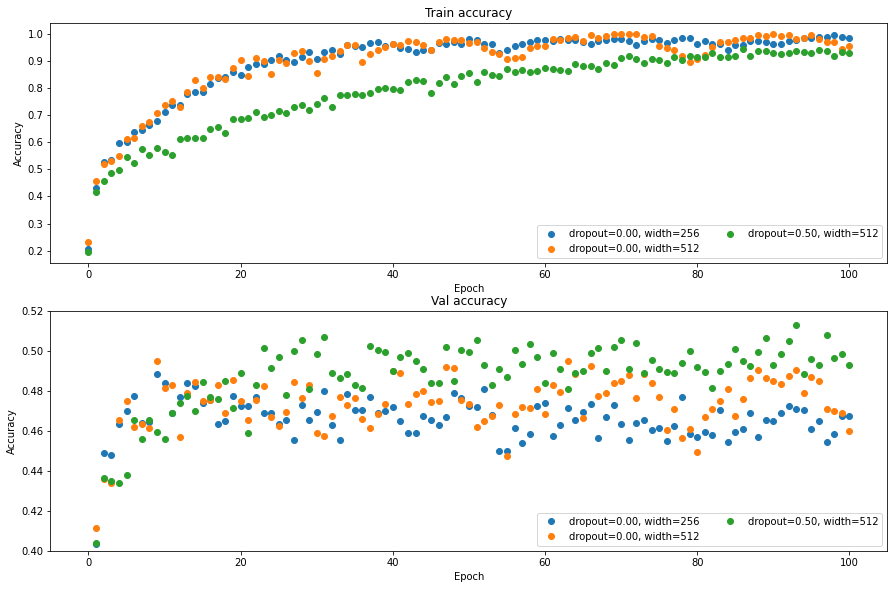

In [48]:
plt.subplot(3, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()